In [55]:
from scipy import *
from scipy import optimize

###########################################################
######## neutrino mass splitting calculation ##############
###########################################################

#### delta m21^2=7.37e-5
#### |delta m^2| = 2.5e-3 (normal) 2.46e-3 (inverted)
d31N = 2.5e-3
d31I = 2.46e-3
d21 = 7.37e-5

m2fcn = lambda m1: sqrt(d21 + m1**2)
m3_NH = lambda m1: sqrt(d31N + 0.5*m2fcn(m1)**2 +0.5*m1**2)
m3_IH = lambda m1: sqrt(0.5*m2fcn(m1)**2 +0.5*m1**2 - d31I)
root_NH = lambda m1, M: M-(m1+m2fcn(m1)+m3_NH(m1))
root_IH = lambda m1, M: M-(m1+m2fcn(m1)+m3_IH(m1))

Mmin_NH = sqrt(d21)+sqrt(d31N+d21/2)
Mmin_IH = sqrt(d31I-0.5*d21) + sqrt(d31I+0.5*d21)
m1min_IH = sqrt(d31I-0.5*d21)

def neutrino_mass_calc (M, split=1):
    '''split = 1, 2, 3 for normal, inverted, degenerate
    '''    
    #print M
    if split == 1:
        m1=optimize.bisect(root_NH, 0, M, args=(M,))       
        m2=m2fcn(m1)
        m3=m3_NH(m1)
    elif split == 2:
        m1=optimize.bisect(root_IH, m1min_IH, M, args=(M,))
        m2=m2fcn(m1)
        m3=m3_IH(m1)
    elif split ==3:
        m1, m2, m3 = ones(3)*M/3.0
    return m1,m2,m3

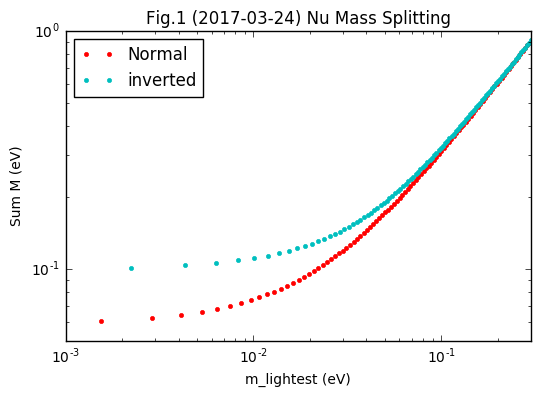

In [56]:
M_NH_arr = logspace(log10(Mmin_NH), 0, 101)
M_IH_arr = logspace(log10(Mmin_IH), 0, 101)

mlight_NH = array([neutrino_mass_calc (iM, split=1) for iM in M_NH_arr])
mlight_IH = array([neutrino_mass_calc (iM, split=2) for iM in M_IH_arr])
loglog(amin(mlight_NH,axis=1), M_NH_arr,'r.',label='Normal')
loglog(amin(mlight_IH,axis=1), M_IH_arr,'c.',label='inverted')
xlabel('m_lightest (eV)')
ylabel('Sum M (eV)')
ylim(5e-2, 1)
xlim(1e-3, 0.3)
legend(loc=0)
title('Fig.1 (2017/03/24) Nu Mass Splitting')
show()

In [6]:
####################################
##### planck error ellipse #########
####################################
#### follows: http://www.visiondummy.com/2014/04/draw-error-ellipse-representing-covariance-matrix/
#### covariance found at: https://wiki.cosmos.esa.int/planckpla/index.php/Cosmological_Parameters

covall=loadtxt('../planck_lowl_lowLike_highL/dist/base_planck_lowl_lowLike_highL_post_lensing.covmat')
covmat=array([covall[i,j] for i in (1,5) for j in (1,5)]).reshape(2,2)
eigvals, eigvec = linalg.eig(covmat)
rmajor, rminor = sqrt(2*5.991*eigvals)
alpha = arctan (eigvec[argmax(eigvals)][1]/eigvec[argmax(eigvals)][0])
#print rmajor, rminor, alpha

0.00699591847762 0.081666030641 1.53588107564


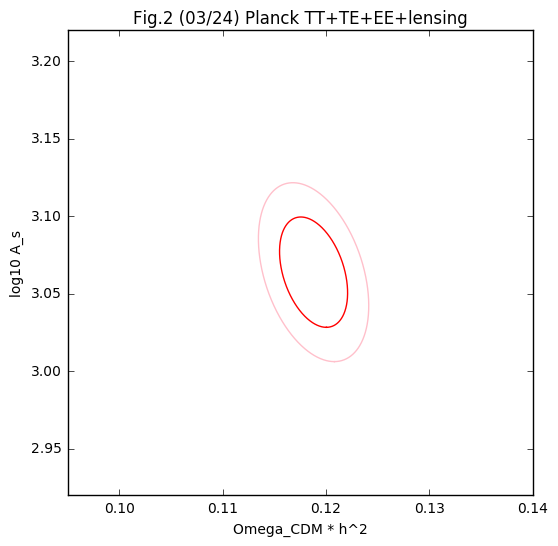

In [87]:
from plot_ellipse import plot_ellipse
f=figure(figsize=(6,6))
ax=f.add_subplot(111)
plot_ellipse(x_cent=0.1188,y_cent=3.064,cov=covmat,mass_level=0.68,ax=ax, plot_kwargs={'color':'r'})
plot_ellipse(x_cent=0.1188,y_cent=3.064,cov=covmat,mass_level=0.95,ax=ax, plot_kwargs={'color':'pink'})
xlabel('Omega_CDM * h^2')
ylabel('log10 A_s')
xlim(0.095, 0.14)
ylim(2.92, 3.22)
ax.set_title('Fig.2 (03/24) Planck TT+TE+EE+lensing')
show()

In [69]:
###########################################
####### cosmological model points #########
###########################################

##### follows: http://www.columbia.edu/~ap3020/LensTools/html/examples/design.html
##### try: https://pythonhosted.org/pyDOE/randomized.html
from pyDOE import *
from scipy.stats.distributions import norm

lhd_grid = lhs(2, samples=100, criterion='m', iterations=1000)


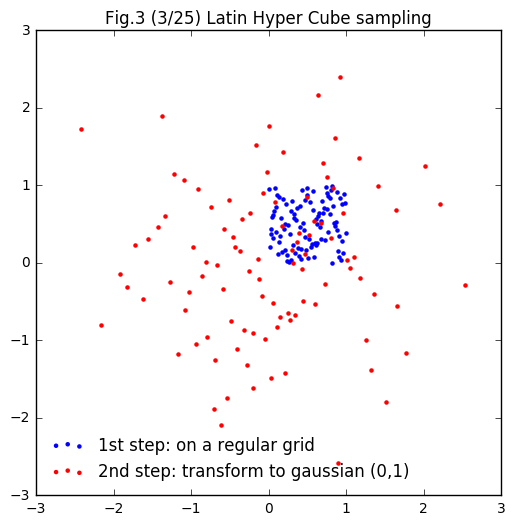

In [100]:
lhd_gaus = norm(loc=0, scale=1).ppf(lhd_grid)
figure(figsize=(6,6))
scatter(lhd_grid.T[0], lhd_grid.T[1], c='b',edgecolors='face',s=5,label='1st step: on a regular grid')
scatter(lhd_gaus.T[0], lhd_gaus.T[1], c='r',edgecolors='face',s=5,label='2nd step: transform to gaussian (0,1)')
xlim(-3,3)
ylim(-3,3)
legend(frameon=0,loc=3)
title('Fig.3 (3/25) Latin Hyper Cube sampling')
show()

In [52]:
data=lhd_gaus.copy()
x_cent=0.1188
y_cent=3.064
mass_level=0.68

eig_vec,eig_val,u = np.linalg.svd(covmat)
# Make sure 0th eigenvector has positive x-coordinate
if eig_vec[0][0] < 0:
    eig_vec[0] *= -1
semimaj = np.sqrt(eig_val[0])
semimin = np.sqrt(eig_val[1])

distances = np.linspace(0,20,20001)
chi2_cdf = chi2.cdf(distances,df=2)
multiplier = np.sqrt(distances[np.where(np.abs(chi2_cdf-mass_level)==np.abs(chi2_cdf-mass_level).min())[0][0]])
semimaj *= multiplier
semimin *= multiplier
phi = np.arccos(np.dot(eig_vec[0],np.array([1,0])))
if eig_vec[0][1] < 0 and phi > 0:
    phi *= -1

S = np.array([[semimaj,0],[0,semimin]])
R = np.array([[np.cos(phi),-np.sin(phi)],[np.sin(phi),np.cos(phi)]])
T = np.dot(R,S)
data_lhc = np.dot(T,data.T)
data_lhc[0] += x_cent
data_lhc[1] += y_cent

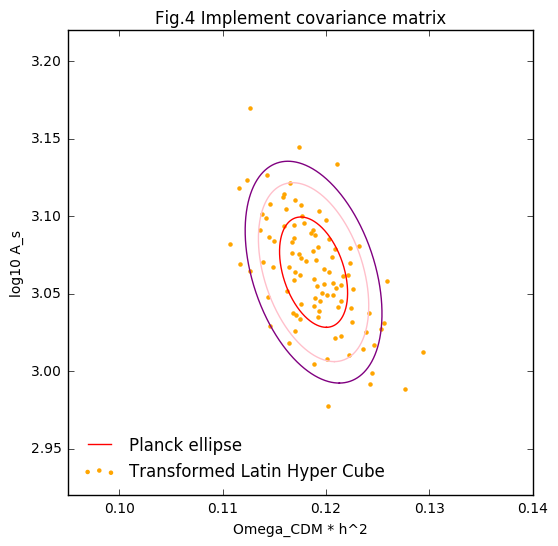

In [106]:
f=figure(figsize=(6,6))
ax=f.add_subplot(111)
plot_ellipse(x_cent=0.1188,y_cent=3.064,cov=covmat,mass_level=0.68,ax=ax, plot_kwargs={'color':'r','label':'Planck ellipse'})
plot_ellipse(x_cent=0.1188,y_cent=3.064,cov=covmat,mass_level=0.95,ax=ax, plot_kwargs={'color':'pink'})
plot_ellipse(x_cent=0.1188,y_cent=3.064,cov=covmat,mass_level=0.99,ax=ax, plot_kwargs={'color':'purple'})
ax.scatter(data_lhc[0],data_lhc[1],c='orange',edgecolors='face',s=5,label='Transformed Latin Hyper Cube')
ax.set_xlabel('Omega_CDM * h^2')
ax.set_ylabel('log10 A_s')
ax.set_xlim(0.095, 0.14)
ax.set_ylim(2.92, 3.22)
legend(frameon=0,loc=3)
ax.set_title('Fig.4 Implement covariance matrix')
show()